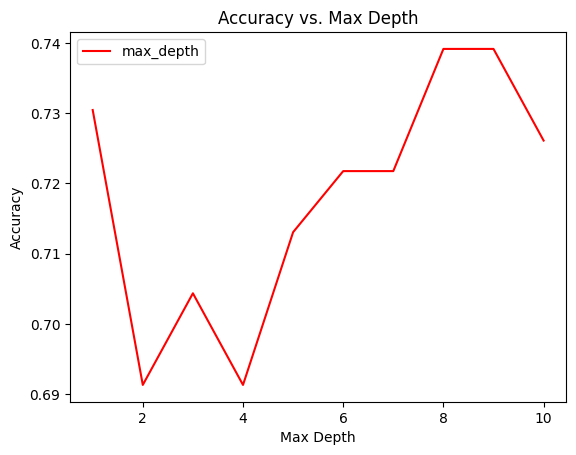

In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load training data
train_data = pd.read_csv('character-deaths.csv')

# Fill missing values in the training data
train_data.fillna({'Death Year': 0, 'Book of Death': 0, 'Death Chapter': 0}, inplace=True)

# Create the 'Death' column (target variable)
train_data['Death'] = train_data['Book of Death'].apply(lambda x: 1 if x > 0 else 0)

# One-hot encode the 'Allegiances' column
Allegiances_dummy = pd.get_dummies(train_data['Allegiances'])
train_data = pd.concat([train_data, Allegiances_dummy], axis=1)

# Drop the original 'Allegiances' column as it's now represented by dummy variables
train_data.drop(['Allegiances'], axis=1, inplace=True)

# Prepare the features (X) and label (y)
X = train_data.drop(['Death', 'Name', 'Death Year', 'Book of Death', 'Death Chapter'], axis=1)
y = train_data['Death']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize an empty list to store accuracy scores for different max_depth values
y_eff = []

# Loop through different max_depth values to test their effect on model performance
for i in range(1, 11):  # Testing max_depth values from 1 to 10
    param_grid = {
        'max_depth': [i],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }
    grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
    
    # Fit the model on the training set
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_clf = grid_search.best_estimator_
    
    # Evaluate model performance on the validation set
    y_val_pred = best_clf.predict(X_val)
    score = accuracy_score(y_val, y_val_pred)
    
    # Append the accuracy score for this max_depth value
    y_eff.append(score)

# Plot the effect of max_depth on accuracy
plt.plot(range(1, 11), y_eff, color="red", label="max_depth")
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Max Depth')
plt.legend()
plt.show()


Best parameters:  {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 5}
Validation Accuracy: 0.72
Validation Precision: 0.47
Validation Recall: 0.44
Confusion Matrix:
[[138  30]
 [ 35  27]]
Cross-validation accuracy: 0.68


'decision_tree.pdf'

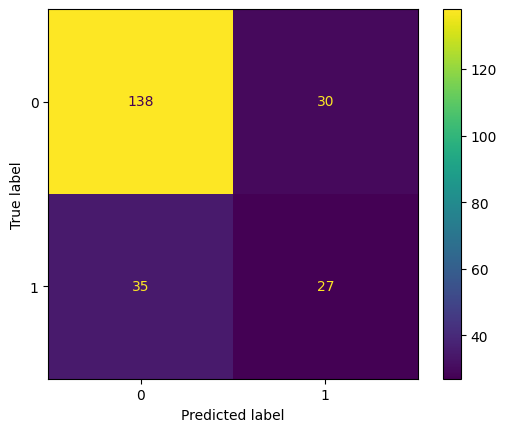

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import graphviz

# Load training data
train_data = pd.read_csv('character-deaths.csv')

# Fill missing values in the training data
train_data.fillna({'Death Year': 0, 'Book of Death': 0, 'Death Chapter': 0}, inplace=True)

# Create the 'Death', column (target variable)
train_data['Death'] = train_data['Book of Death'].apply(lambda x: 1 if x > 0 else 0)

# One-hot encode the 'Allegiances' column
train_data = pd.get_dummies(train_data, columns=['Allegiances'])
train_data = pd.concat([train_data, Allegiances_dummy], axis=1)




# Prepare the features (X) and label (y)
X = train_data.drop(['Death', 'Name', 'Death Year', 'Book of Death', 'Death Chapter'], axis=1)
y = train_data['Death']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'max_depth': [8,9,10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best hyperparameters from the grid search
print("Best parameters: ", grid_search.best_params_)

# Train the model using the best parameters
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)

# Evaluate the model on the validation set
y_val_pred = best_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)

print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Validation Precision: {val_precision:.2f}")
print(f"Validation Recall: {val_recall:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Cross-validation score
cv_scores = cross_val_score(best_clf, X, y, cv=5)
print(f"Cross-validation accuracy: {cv_scores.mean():.2f}")


ConfusionMatrixDisplay.from_estimator(best_clf,X_val,y_val)





dot_data = export_graphviz(best_clf, out_file=None, 
                           feature_names=X.columns, 
                           class_names=['Alive', 'Dead'], 
                           filled=True, rounded=True, 
                           special_characters=True)

# Use graphviz to render the tree
graph = graphviz.Source(dot_data)  
graph.render("decision_tree")  # This will create a file "decision_tree.pdf"
graph.view()


In [58]:
# Load test data
test_data = pd.read_csv('test.csv')

# Store the 'Character' column separately before preprocessing
character_column = test_data[['Character']]

# One-hot encode the 'Allegiances' column in the test data
Allegiances_dummy = pd.get_dummies(test_data['Allegiances'])
test_data = pd.concat([test_data, Allegiances_dummy], axis=1)
test_data.drop(['Allegiances'], axis=1, inplace=True)

# Ensure test data has the same columns as training data
# Add missing columns to the test set and set them to 0
for col in X.columns:
    if col not in test_data.columns:
        test_data[col] = 0

# Ensure all columns in test_data are in the same order as the training set
test_data = test_data[X.columns]

# Predict the 'Death' column using the trained classifier
y_test_pred = best_clf.predict(test_data)

# Create a new DataFrame with 'Character' and predicted 'Death'
output_data = character_column.copy()  # Restore 'Character' column
output_data['Death'] = y_test_pred

# Save the output to a CSV file
output_data.to_csv('output_predictions.csv', index=False)

print("Predictions saved to 'output_predictions.csv'")


Predictions saved to 'output_predictions.csv'
